In [2]:
%matplotlib inline
import numpy as np
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats
import pymc as pm

In [3]:
def gen_sample(n, mus, sigmas):
    return np.array([mus + stats.norm.rvs(size = n, loc = 0, scale = sigmas[i]) for i in np.arange(len(sigmas)) ])

def gen_mus_sigma(nb_stateux, nb_samples):
    return (stats.uniform.rvs(size=nb_samples, loc=0, scale=200), stats.uniform.rvs(size=nb_stateux, loc=0, scale=40))

nb_stateux = 7
sample_length = 10

(mus, sigma) = gen_mus_sigma(nb_stateux, sample_length)
sample = gen_sample(sample_length, mus, sigma)
print len(sample), len(sample[0])
print mus
print sigma
print sample
print [np.mean([sample[i, j] for i in np.arange(len(sigma))]) for j in np.arange(len(mus))]


7 10
[ 146.64338929  136.99757862   90.01666553   99.26001533  151.59895805
  127.81343441  119.87062122  195.43096954  167.09822408  174.7435911 ]
[  4.66868271  11.10191178  12.80058265  18.83626899  16.60474538
  19.94403699  19.18336397]
[[ 148.21980259  137.75843764   92.07740864   97.60600186  150.76135926
   131.90609221  116.8034207   198.84092779  172.77529541  166.2882819 ]
 [ 144.60918215  145.66124086   96.08030956  106.91342976  143.09801359
   140.9406048   122.85322154  192.14828551  165.93320752  157.14959715]
 [ 159.52615106  160.08995214   87.82703758   91.85106367  156.48552131
   117.63937203  119.71114861  195.54746251  163.91368779  164.69472218]
 [ 148.14454207  134.31130237   87.62767746  111.76070694  161.94222752
   109.19687715  146.82228203  193.86595579  153.66681176  180.95647638]
 [ 125.57656489  120.41830395   68.79714451  117.8281456   150.1170355
   119.66157089  115.81770641  188.82017279  187.2810488   162.39591612]
 [ 182.2634143   149.44658767   97

In [16]:
v_mus = np.array([pm.Normal("mu%d" % i, mu=0, tau=0.001) for i in np.arange(sample_length)])

v_taus = [pm.Gamma("tau%d" % k, alpha=0.01, beta=0.0001) for k in np.arange(nb_stateux)] # or beta 0.001? alpha 0? 0.001?
v_sigmas = [pm.Lambda("sigma%d" % k, lambda tau=v_taus[k]: 1./np.sqrt(tau)) for k in np.arange(nb_stateux)]

x = np.array([[pm.Normal("x%d_%d" % (k,i), mu=v_mus[i], tau=v_taus[k], 
                         observed=True, value=np.array(sample[k,i])) for i in np.arange(sample_length)]
              for k in np.arange(nb_stateux)])

print x.shape

(7L, 10L)


In [17]:
mcmc = pm.MCMC([v_mus, v_sigmas, v_taus, x])
mcmc.sample(10000, burn=2000)

 [-----------------100%-----------------] 10000 of 10000 complete in 55.1 sec

36.0106305586
34.1070201222
19.4379080719
21.76507545
33.9850632218
25.5046364581
28.4185292955
44.4572474313
36.7753321003
39.0750548549
[36.010630558558802, 34.107020122213108, 19.437908071856391, 21.765075450003554, 33.985063221821299, 25.504636458095206, 28.418529295503241, 44.457247431336143, 36.775332100317044, 39.075054854862358]


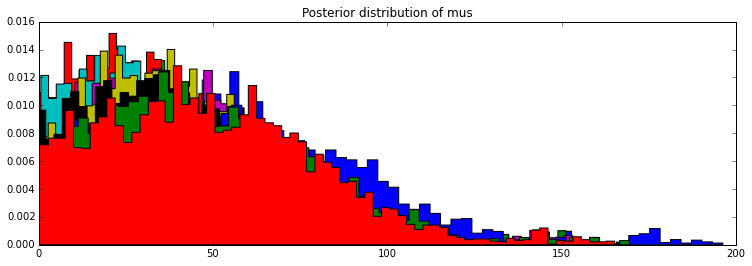

In [19]:
figsize(12.5, 4)
plt.title("Posterior distribution of mus")
for i in np.arange(sample_length):
    plt.hist(mcmc.trace("mu%d" % i)[:], bins=100, histtype="stepfilled", normed=True)
    plt.legend()
    plt.xlim((0,200))
    print (mcmc.trace("mu%d" % i)[:].mean())

print [mcmc.trace("mu%d" % j)[:].mean() for j in np.arange(sample_length)]

4.0652091833e+44
3.32838296077e+14
1.16099867298
5.60162282068e+26
7507435246.82
2.38164261455e+26
117.425214035


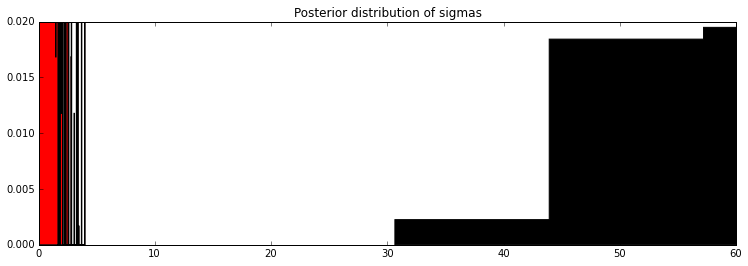

In [38]:
figsize(12.5, 4)
plt.title("Posterior distribution of sigmas")
for i in np.arange(nb_stateux):
    plt.hist(mcmc.trace("sigma%d" % i)[:], bins=100, histtype="stepfilled", normed=True)
    plt.legend()
    plt.xlim((0,60))
    print (mcmc.trace("sigma%d" % i)[:].mean())


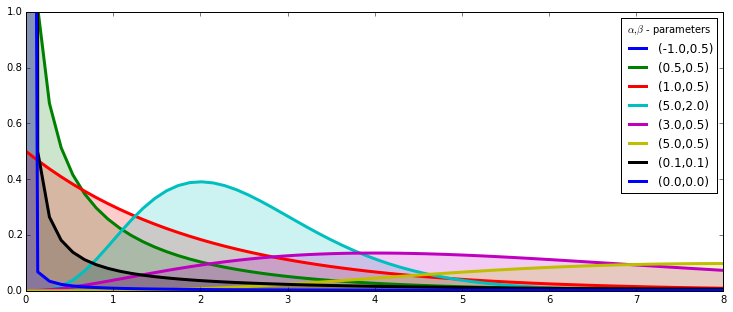

In [12]:
#Gammas
figsize(12.5, 5)
gamma = stats.gamma

parameters = [(-1, 0.5), (0.5, 0.5),(1, 0.5), (5, 2), (3, 0.5), (5, 0.5), (0.1, 0.1), (0.01, 0.001)]
x = np.linspace(0.001, 20, 150)
for alpha, beta in parameters:
    y = gamma.pdf(x, alpha, scale=1. / beta)
    lines = plt.plot(x, y, label="(%.1f,%.1f)" % (alpha, beta), lw=3)
    plt.fill_between(x, 0, y, alpha=0.2, color=lines[0].get_color())
    plt.autoscale(tight=True)
plt.xlim((0,8))
plt.ylim((0,1))
plt.legend(title=r"$\alpha, \beta$ - parameters");